In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'camp', 'kid', 'program',
                   'school', 'offer', 'student', 'children', 'class', 'classes', 'education',
                  'academy', 'institution'])

In [3]:
df = pd.read_csv('activity-hero-new.csv')
df = df.drop('location.1',axis=1)# df.columns = list(range(8))
df.head()

,title,location,category,image,description,details,provider,distance,ages,price,campus
0,KidzToPros,Multiple Locations,Hip Hop Online Course Free Activities,https://images.activityhero.com/provider_photo...,From coding in scratch and python to LEGO Mast...,https://www.activityhero.com/biz/kidztopros,https://images.activityhero.com/59989/crop/bfc...,7.0,"5, 17",140,m
1,Petits Pas,Multiple Locations,Crafts Dance Yoga,https://images.activityhero.com/provider_photo...,"By combining a variety of classes (Yoga, Balle...",https://www.activityhero.com/biz/petits-pas,https://images.activityhero.com/58965/crop/399...,12.9,"5, 17",0,f
2,Crissy Field Center Summer Camp,"Crissy Field Center - San Francisco, CA",Nature Programs Backpacking Adventure/Outdoors,https://images.activityhero.com/provider_photo...,About Crissy Field CenterThe Crissy Field Cent...,https://www.activityhero.com/biz/2575-crissy-f...,https://images.activityhero.com/2179/crop/de98...,23.9,",18",100,"m,f"
3,Early Childhood Matters,Multiple Locations,Family Mindfulness Preschool,https://images.activityhero.com/provider_photo...,Supporting Families on the Road to Connected a...,https://www.activityhero.com/biz/early-childho...,https://images.activityhero.com/57089/crop/989...,24.6,"5,18",45,"m,f"
4,Art School of SF Bay,Multiple Locations,Cartooning Visual Arts Drawing and Painting,https://images.activityhero.com/provider_photo...,We teach classical art - in a modern way. Our ...,https://www.activityhero.com/biz/art-school-of...,https://images.activityhero.com/10531/crop/150...,25.0,"5, 17",110,"m,f"


In [4]:
description_df = df[['description']]

# Convert to list
data = description_df.description.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub("read more >", "", sent) for sent in data]

pprint(data[:1])

['From coding in scratch and python to LEGO Masters, graphic design, art '
 'skills, sports and more, KidzToPros takes fun and enrichment to the next '
 'level! Our…']


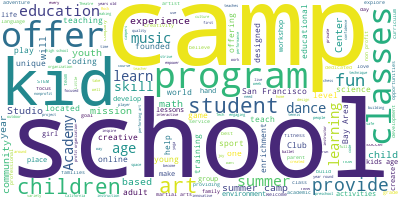

In [5]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(data)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'coding', 'in', 'scratch', 'and', 'python', 'to', 'lego', 'masters', 'graphic', 'design', 'art', 'skills', 'sports', 'and', 'more', 'kidztopros', 'takes', 'fun', 'and', 'enrichment', 'to', 'the', 'next', 'level', 'our']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'coding', 'in', 'scratch', 'and', 'python', 'to', 'lego', 'masters', 'graphic', 'design', 'art', 'skills', 'sports', 'and', 'more', 'kidztopros', 'takes', 'fun', 'and', 'enrichment', 'to', 'the', 'next', 'level', 'our']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['code', 'scratch', 'python', 'lego', 'master', 'graphic', 'design', 'art', 'skill', 'sport', 'kidztopros', 'take', 'fun', 'enrichment', 'next', 'level']]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]]


In [11]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('art', 1),
  ('code', 1),
  ('design', 1),
  ('enrichment', 1),
  ('fun', 1),
  ('graphic', 1),
  ('kidztopros', 1),
  ('lego', 1),
  ('level', 1),
  ('master', 1),
  ('next', 1),
  ('python', 1),
  ('scratch', 1),
  ('skill', 1),
  ('sport', 1),
  ('take', 1)]]

In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.138*"create" + 0.099*"club" + 0.075*"girl" + 0.070*"world" + 0.045*"boy" '
  '+ 0.030*"encourage" + 0.030*"clinic" + 0.023*"go" + 0.019*"wide_range" + '
  '0.018*"positive"'),
 (1,
  '0.063*"year_round" + 0.058*"full" + 0.045*"potential" + 0.038*"become" + '
  '0.036*"real" + 0.034*"spark" + 0.034*"field" + 0.032*"culture" + '
  '0.029*"healthy" + 0.028*"reach"'),
 (2,
  '0.070*"play" + 0.065*"online" + 0.065*"day" + 0.065*"new" + 0.056*"found" + '
  '0.051*"locate" + 0.041*"well" + 0.031*"grow" + 0.025*"silicon_valley" + '
  '0.025*"little"'),
 (3,
  '0.087*"team" + 0.056*"run" + 0.055*"tech" + 0.039*"week" + 0.037*"session" '
  '+ 0.036*"kind" + 0.030*"large" + 0.026*"weekly" + 0.021*"wonderful" + '
  '0.021*"feature"'),
 (4,
  '0.121*"child" + 0.087*"educational" + 0.066*"development" + 0.061*"science" '
  '+ 0.037*"adventure" + 0.035*"use" + 0.031*"personal" + 0.031*"city" + '
  '0.021*"park" + 0.019*"mean"'),
 (5,
  '0.137*"make" + 0.098*"game" + 0.051*"serve" + 0.047*"p

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.307371364968471

Coherence Score:  0.4374309002541324


In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.354857  0.095448       1        1  17.201445
17     0.312558  0.085381       2        1  13.391040
11     0.145720 -0.364371       3        1   8.830618
2     -0.018509  0.013378       4        1   6.567773
14    -0.012380  0.032938       5        1   6.127347
4     -0.038524  0.008441       6        1   4.714269
8     -0.040725  0.021553       7        1   4.675488
6     -0.032554  0.012702       8        1   4.588497
10    -0.031303  0.010519       9        1   4.537398
13    -0.033888  0.008306      10        1   4.416656
9     -0.053479  0.006519      11        1   3.493901
0     -0.053550  0.010158      12        1   3.430162
18    -0.052715  0.005985      13        1   3.122365
12    -0.051036  0.006266      14        1   2.874045
5     -0.061441  0.006677      15        1   2.610776
1     -0.062110  0.013968      16        1   2.591150
7     -0.056967  0.006272      17        1   2.516762
3     -0.065406  0.006667      18        1   2.185825
19    -0.071220  0.006673      19        1   1.277699
15    -0.077326  0.006518      20        1   0.846790, topic_info=          Term        Freq       Total Category  logprob  loglift
136    provide  199.000000  199.000000  Default  30.0000  30.0000
0          art  208.000000  208.000000  Default  29.0000  29.0000
174      learn  221.000000  221.000000  Default  28.0000  28.0000
62     student  219.000000  219.000000  Default  27.0000  27.0000
68         kid  308.000000  308.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1159   perfect    0.026689    1.102923  Topic20  -8.3109   1.0500
979   educator    0.026690    1.102956  Topic20  -8.3108   1.0500
680   activity    0.026693    1.103319  Topic20  -8.3107   1.0498
852       need    0.026691    1.103140  Topic20  -8.3108   1.0499
1287      tool    0.026690    1.103012  Topic20  -8.3108   1.0500

[712 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
267       3  0.970255    academic
340       7  0.554059  accessible
566      18  0.737647    accredit
621       6  0.820814     achieve
365       9  0.857877         act
...     ...       ...         ...
229      16  0.949378  year_round
411       6  0.946944   years_old
28        2  0.922428        yoga
246      10  0.974139       young
156       9  0.986427       youth

[484 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 18, 12, 3, 15, 5, 9, 7, 11, 14, 10, 1, 19, 13, 6, 2, 8, 4, 20, 16])

In [16]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(9,
  [('dance', 0.12110726643598616),
   ('offer', 0.0986159169550173),
   ('company', 0.058823529411764705),
   ('training', 0.05536332179930796),
   ('professional', 0.0328719723183391),
   ('include', 0.0328719723183391),
   ('love', 0.0328719723183391),
   ('ballet', 0.031141868512110725),
   ('year_round', 0.031141868512110725),
   ('theatre', 0.029411764705882353)]),
 (0,
  [('experience', 0.11486486486486487),
   ('learning', 0.057432432432432436),
   ('inspire', 0.04391891891891892),
   ('language', 0.04391891891891892),
   ('teacher', 0.033783783783783786),
   ('teaching', 0.03209459459459459),
   ('preschool', 0.03209459459459459),
   ('week', 0.028716216216216218),
   ('home', 0.028716216216216218),
   ('spanish', 0.02195945945945946)]),
 (14,
  [('day', 0.06969205834683954),
   ('world', 0.06969205834683954),
   ('adventure', 0.04376012965964344),
   ('explore', 0.04376012965964344),
   ('grow', 0.02593192868719611),
   ('park', 0.024311183144246355),
   ('space', 0.02269

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
# takes a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

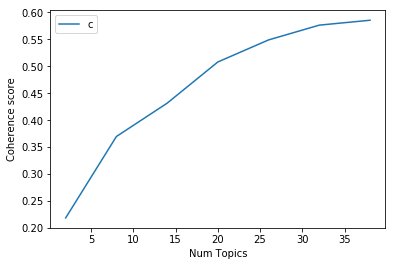

In [19]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2186
Num Topics = 8  has Coherence Value of 0.3697
Num Topics = 14  has Coherence Value of 0.4316
Num Topics = 20  has Coherence Value of 0.5081
Num Topics = 26  has Coherence Value of 0.549
Num Topics = 32  has Coherence Value of 0.5765
Num Topics = 38  has Coherence Value of 0.5856


In [21]:
# Select the model and print the topics
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
pprint(sorted(optimal_model.print_topics(num_words=10), key=lambda x: x[0]))

[(0,
  '0.099*"life" + 0.049*"family" + 0.043*"enjoy" + 0.039*"movement" + '
  '0.039*"large" + 0.036*"yoga" + 0.033*"real" + 0.033*"part" + '
  '0.026*"background" + 0.023*"chef"'),
 (2,
  '0.245*"student" + 0.117*"activity" + 0.048*"academic" + 0.048*"virtual" + '
  '0.045*"steam" + 0.041*"session" + 0.024*"ca" + 0.017*"form" + '
  '0.014*"overnight" + 0.014*"guitar"'),
 (6,
  '0.096*"love" + 0.078*"language" + 0.062*"engage" + 0.040*"encourage" + '
  '0.037*"spanish" + 0.037*"american" + 0.037*"immersion" + '
  '0.028*"instruction" + 0.028*"mandarin" + 0.025*"excite"'),
 (9,
  '0.179*"design" + 0.083*"program" + 0.074*"develop" + 0.067*"skill" + '
  '0.058*"teaching" + 0.051*"discover" + 0.045*"inspire" + 0.032*"age" + '
  '0.026*"home" + 0.022*"critical"'),
 (13,
  '0.184*"create" + 0.133*"make" + 0.051*"write" + 0.048*"teacher" + '
  '0.027*"weekly" + 0.024*"educate" + 0.024*"basic" + 0.020*"technique" + '
  '0.020*"perform" + 0.017*"resource"'),
 (15,
  '0.150*"kid" + 0.106*"onli

In [22]:
list(enumerate(optimal_model[corpus]))[:5]

[(0,
  [(0, 0.02055921052631578),
   (1, 0.02055921052631578),
   (2, 0.02055921052631578),
   (3, 0.039656432748537994),
   (4, 0.02055921052631578),
   (5, 0.04486476608187133),
   (6, 0.022295321637426892),
   (7, 0.02055921052631578),
   (8, 0.03618421052631578),
   (9, 0.04486476608187133),
   (10, 0.02750365497076022),
   (11, 0.02055921052631578),
   (12, 0.022295321637426892),
   (13, 0.02055921052631578),
   (14, 0.029239766081871336),
   (15, 0.02750365497076022),
   (16, 0.025767543859649113),
   (17, 0.02055921052631578),
   (18, 0.02055921052631578),
   (19, 0.029239766081871336),
   (20, 0.02055921052631578),
   (21, 0.02055921052631578),
   (22, 0.025767543859649113),
   (23, 0.02055921052631578),
   (24, 0.022295321637426892),
   (25, 0.02055921052631578),
   (26, 0.02055921052631578),
   (27, 0.03618421052631578),
   (28, 0.02055921052631578),
   (29, 0.03271198830409356),
   (30, 0.02055921052631578),
   (31, 0.022295321637426892),
   (32, 0.02055921052631578),
   (33

### Finding the dominant topic in each sentence

In [23]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Topic Mapping
    import json
    topics_mapping_file = open('topics_mapping.json')
    topic_mapping = json.loads(topics_mapping_file.read())
    topics_mapping_file.close()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                # topic_keywords = ", ".join([word for word, prop in wp])
                prop_sum = sum([prop for word, prop in wp])
                topic_keywords = [[word, round((prop/prop_sum)*100, 2)] for word, prop in wp]
                sent_topics_df = sent_topics_df.append(pd.Series([topic_mapping[str(topic_num)], round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10).style.background_gradient(cmap='Blues')

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,STEM,0.051800,"[['center', 24.62], ['enrichment', 23.62], ['math', 23.12], ['empower', 6.53], ['opportunity', 4.52], ['english', 4.52], ['visual', 3.52], ['concept', 3.52], ['oakland', 3.52], ['aerial', 2.51]]","From coding in scratch and python to LEGO Masters, graphic design, art skills, sports and more, KidzToPros takes fun and enrichment to the next level! Our…"
1,1,Arts,0.047300,"[['dance', 34.74], ['training', 14.21], ['variety', 10.53], ['ballet', 10.53], ['performing_arts', 8.42], ['joy', 7.89], ['exciting', 3.68], ['proud', 3.68], ['blend', 3.16], ['curriculum', 3.16]]","By combining a variety of classes (Yoga, Ballet, Barre au sol & Modern jazz), Petits Pas celebrates our senses and teaches us to express ourselves through…"
2,2,Sports,0.086900,"[['love', 20.53], ['language', 16.56], ['engage', 13.25], ['encourage', 8.61], ['spanish', 7.95], ['american', 7.95], ['immersion', 7.95], ['instruction', 5.96], ['mandarin', 5.96], ['excite', 5.3]]","About Crissy Field CenterThe Crissy Field Center’s mission is to encourage new generations to become bold leaders for thriving parks, healthy communities,…"
3,3,Sports,0.052600,"[['year', 32.76], ['soccer', 16.67], ['serve', 10.92], ['run', 9.77], ['begin', 7.47], ['coach', 6.9], ['super', 4.6], ['north', 4.02], ['challenging', 3.45], ['competitive', 3.45]]",Supporting Families on the Road to Connected and Effective ParentingEarly Childhood Matters focuses on the early years (0-5) where the most crucial brain…
4,4,STEM,0.055300,"[['art', 52.43], ['studio', 20.39], ['creative', 10.03], ['artist', 8.41], ['fine', 2.59], ['children', 1.94], ['offer', 1.62], ['mind', 0.97], ['method', 0.97], ['excitement', 0.65]]","We teach classical art - in a modern way. Our classes are fun and effective, our methods creative and our students’ results are spectacular!We teach our…"
5,5,Arts,0.084400,"[['kid', 65.74], ['age', 22.31], ['pm', 2.39], ['option', 1.99], ['moment', 1.59], ['offering', 1.59], ['quantum', 1.2], ['scholarship', 1.2], ['main', 1.2], ['mark', 0.8]]",Quantum Martial Arts is a nonprofit community dojo in the heart of San Franciscos Mission District. We teach non-competitive Tae Kwon Do to our kids…
6,6,Arts,0.096300,"[['dance', 34.74], ['training', 14.21], ['variety', 10.53], ['ballet', 10.53], ['performing_arts', 8.42], ['joy', 7.89], ['exciting', 3.68], ['proud', 3.68], ['blend', 3.16], ['curriculum', 3.16]]","Welcome to Geary Dance Center, the San Francisco Richmond Districts newest center for dance excellence! We offer a wide variety of dance classes for…"
7,7,Arts,0.061400,"[['life', 23.44], ['family', 11.72], ['enjoy', 10.16], ['movement', 9.38], ['large', 9.38], ['yoga', 8.59], ['real', 7.81], ['part', 7.81], ['background', 6.25], ['chef', 5.47]]",Yoga matters NOW more than ever! Be YOUR Best with evidence-based mindset and movement practices that build healthy sustainable habits for happy…
8,8,Sports,0.070300,"[['summer', 42.99], ['camp', 35.83], ['break', 5.3], ['spring', 3.12], ['baseball', 2.8], ['week_long', 2.49], ['athletic', 2.18], ['hold', 1.87], ['holiday', 1.87], ['aim', 1.56]]",Garden Camp registration is tentatively closed as we work to re-configure our summer sessions to meet San Francisco Health Order and Summer Camp Directive…
9,9,STEM,0.062200,"[['music', 35.81], ['lesson', 17.21], ['group', 11.16], ['private', 8.37], ['rock', 7.44], ['approach', 4.65], ['specialize', 4.65], ['give', 4.19], ['piano', 4.19], ['ca', 2.33]]","DogCamp for Kids, 9am-3pm, brings children and dogs together in a natural setting. Drop Off/ Pick Up in Golden Gate Park, near Polo Fields. Based on our…"


/home/srichakradhar/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


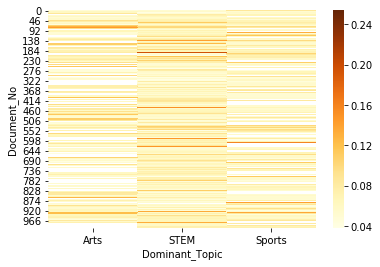

In [24]:
import seaborn as sns
topic_correlation_df = df_dominant_topic[['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib']]
heatmap_data = pd.pivot_table(topic_correlation_df, values='Topic_Perc_Contrib', 
                     index=['Document_No'], 
                     columns='Dominant_Topic')
sns.heatmap(heatmap_data, cmap="YlOrBr")

### Most representative document for each topic

In [25]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,Arts,0.1445,"[[life, 23.44], [family, 11.72], [enjoy, 10.16...",Rainbow Chefs empowers aspiring chefs to devel...
1,STEM,0.2539,"[[mission, 14.29], [space, 12.78], [open, 12.7...",The spirit of the West meets Silicon Valley at...
2,Sports,0.1594,"[[summer, 42.99], [camp, 35.83], [break, 5.3],...",Spring Down Equestrian Center offers three dif...


### Topic distribution across documents

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

In [ ]:
df_keywords = df_dominant_topic[['Document_No', 'Dominant_Topic', 'Keywords']]
df_keywords.columns = ['id', 'camp_type', 'topics']
result = pd.concat([df, df_keywords[['camp_type', 'topics']]], axis=1)
result.reset_index(drop=True, inplace=True)
result.to_excel('result.xlsx')

In [ ]:
df.columns

In [ ]:
import json
result_file = open('result_1.json')
result_json = json.loads(result_file.read())
result_file.close()
new_result = [
  {
    "title": "Computer Science",
    "id": 1,
    "count": 404,
    "programs": []
  },
  {
    "title": "Arts and Design",
    "id": 2,
    "count": 394,
    "programs": []
  },
  {
    "title": "Math & Logic",
    "id": 3,
    "count": 435,
    "programs": []
  },
  {
    "title": "Personal Development",
    "count": 246,
    "id": 4,
    "programs": []
  }
]

category_map = {
    "Math & Logic": 2,
    "Arts and Design": 1,
    "Personal Development": 3,
    "Computer Science": 0,
}

program = {
    "id": 1,
    "title": "Program One",
    "avatar": "https://ionicframework.com/docs/demos/api/card/madison.jpg",
    "description": "Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum",
    "price": 12,
    "relevance": 91,
    "category": "STEM",
    "sub_category": "Preschool Nature Programs Play/Outdoor",
    "location": "ASHEVILLE NC US",
    "affordability": "38.82",
    "details": "details",
    "provider": "provider",
    "distance": 12.9,
    "ages": "5, 17",
    "campus": "m,f",
    "camp_type": "STEM",
    "topics": [['fun', 48.56], ['environment', 12.5], ['engage', 11.54], ['hand', 7.21], ['great', 5.29], ['local', 4.81], ['year', 3.85], ['personal', 2.4], ['perfect', 1.92], ['fill', 1.92]],    
}

for row in result_json:
    new_result[category_map[row['category']]]['programs'].append({key: row[key] for key in program.keys()})

In [ ]:
def set_default(obj):
    if isinstance(obj, set):
        return list(obj)
    raise TypeError

with open('result_final.json', 'w') as fp:
    json.dump(new_result, fp, indent=2, default=set_default)

Ref: [machinelearningplus](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python)